In [1]:
from Bio import Phylo, SeqIO
import pandas as pd
import os
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
from matplotlib.colors import ListedColormap

tree_path = "phylo_2019_h3n2.nwk.refine" #


In [2]:
year = 2019
subtype="h3n2"
month="02"
index=(year - 2019) * 2 + 32

vaccine_scores_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=%d-%s-%d-%s___virus_set=%d-%s-%d-%s/vaccine_scores/prob=weight_loss_by_count_lightning_logs_version_0___hi=max_steps_150k/vaccine_score_and_gt.csv" % (year, month, subtype, year-3, month, year, month, year-3, month, year, month)
vaccine_scores = pd.read_csv(vaccine_scores_path)

df_hi = pd.read_csv("../../runs/pipeline/%d-%s/a_%s/vaccine_set=%d-%s-%d-%s___virus_set=%d/vaccine_virus_pairs/prediction/lightning_logs/version_0/predictions.csv" % (year, month, subtype, year-3, month, year, month, index))

ref_to_virus = defaultdict(dict)
for ref, vir, hi in zip(df_hi["reference"], df_hi["virus"], df_hi["label"]):
    ref_to_virus[ref][vir] = hi

In [3]:
virus_fasta_path = os.path.join("../../data/gisaid/ha_processed/2003-10_to_2023-04_6M/a_%s/human_minBinSize100_lenQuantile0.2_bins" % subtype, "%d.fasta" % (index))
records = SeqIO.parse(virus_fasta_path, "fasta")
acc_ids = [x.id for x in records]


In [4]:
best_strain = vaccine_scores["reference"][np.argmin(vaccine_scores["score"])]
print(best_strain)

our_accid2hi = {i: -ref_to_virus[best_strain][i] for i in acc_ids}


EPI1321475


In [5]:
ve_path = "../../data/vaccine_effectiveness/ve_%s.csv" % subtype
ve = pd.read_csv(ve_path)
# print(ve)
ve["Year"] = [int(x.split("-")[0]) for x in ve["Year"]]
year2who_strain_names = dict(zip(ve["Year"], ve["Strain"]))
# print(year2who_strain_names)

who_strain_name = year2who_strain_names[year]

print(who_strain_name)

def _include(ref_strain_names, query_strain_names):
    for ref_strain in ref_strain_names:
        if ref_strain in query_strain_names:
            return True
    return False

who_strains_bin = np.asarray([_include(who_strain_name.split("|"), x.split("|")) for x in vaccine_scores["strain_name"]])
# max(who_strain)
who_strains = vaccine_scores["reference"][who_strains_bin]
print(who_strains)

who_accid2hi = {i: -np.mean([ref_to_virus[v][i] for v in who_strains]) for i in acc_ids}
# print(who_accid2hi)
# who_his = np.stack([np.asarray([ref_to_virus[s][vir_id] for vir_id in ids]) for s in who_strains], axis=0)
# print(his.shape)
# who_his = np.mean(his, axis=0)

A/Kansas/14/2017
474    EPI1146345
Name: reference, dtype: object


In [6]:
import seaborn as sns
pal = sns.color_palette("ch:s=.25,rot=-.25", 100)
# pal = sns.color_palette("rocket")
# print(pal[0.1])
color_map = sns.color_palette("ch:s=.25,rot=-.25", 100).as_hex()
# print(len(pal))

In [7]:
tree = Phylo.read(tree_path, "newick") # .next()
tree_nodes2acc_ids = {}
clades = tree.get_terminals()
for node in clades:
    tree_nodes2acc_ids[node] = node.name
tree.rooted = True


In [8]:

sns.set(font_scale=1.5, style="ticks")

def plot(name2value, strain_name):
    clades = tree.get_terminals()
    
    # Set color for leaves
    v_max = max(name2value.values()) + 1e-3
    v_min = min(name2value.values()) - 1e-3
    for node in clades:
        c = tree_nodes2acc_ids[node]
        v = int(((name2value[c] - v_min) / (v_max - v_min)) * 100)
#         print(v)
        node.color = color_map[v]
        node.name = ""
    
    # Set color for non-leaves
    for clade in tree.get_nonterminals():
        clade.color = "#ECECEC"
        clade.name = ""
    
    plt.rcParams.update({'font.size': 15})


    fig = plt.figure(figsize=(5, 5), dpi=100)
#     fig = plt.figure(dpi=100)
    axes = fig.add_subplot(1, 1, 1)

    Phylo.draw(tree, branch_labels=lambda c: "", axes=axes, do_show=False)
    # Phylo.draw(tree, axes=axes, label_func=get_label)


    cmap = mpl.colormaps['viridis']
    cmap = ListedColormap(color_map)


    scalar_mappable = matplotlib.cm.ScalarMappable(cmap=cmap)
    scalar_mappable.set_array(list(name2value.values()))
    cbar = plt.colorbar(ax=axes, mappable=scalar_mappable, )
    # cbar.solids.set_edgecolor("face")
    cbar.set_label('Predicted negative HI values')

    plt.xlabel('Pseudo-time')
    plt.title("Vaccine strain: %s" % strain_name)

    import os

    fig_name = os.path.split(tree_path)[-1] + "." + strain_name.replace("/", "_")

    print(fig_name)
    plt.savefig(os.path.join("figs", fig_name + ".pdf"), format="pdf", bbox_inches="tight")


    plt.show()

phylo_2019_h3n2.nwk.refine.WHO


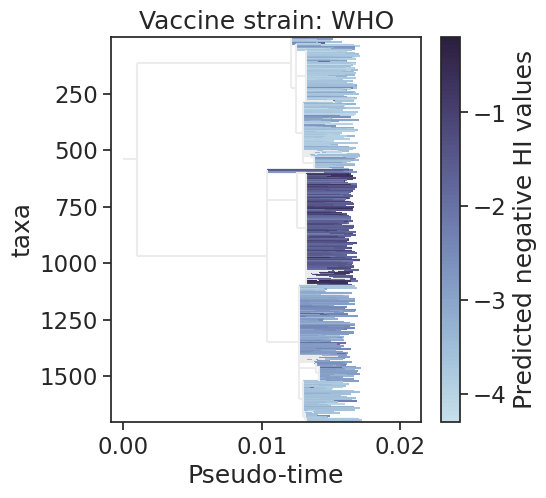

In [9]:
plot(who_accid2hi, "WHO")

phylo_2019_h3n2.nwk.refine.VaxSeer


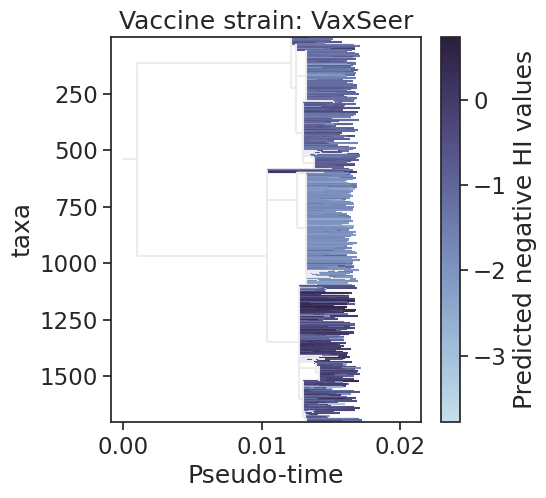

In [10]:
plot(our_accid2hi, "VaxSeer")

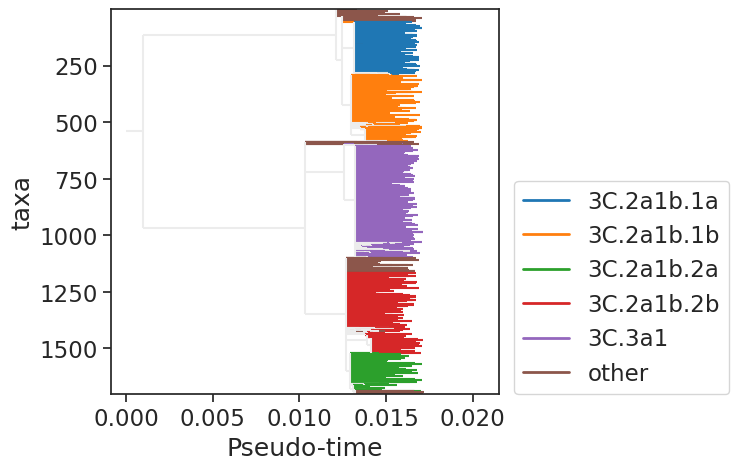

In [22]:
from matplotlib.lines import Line2D


def plot_clade(name2clade):
    color_map = sns.color_palette("tab10", 10).as_hex()
    clades = tree.get_terminals()
    
    all_clade = list(set(name2clade.values()))
    all_clade.sort()
    clade2index = {c:i for i,c in enumerate(all_clade)}
    for node in clades:
        c = tree_nodes2acc_ids[node]
        v = clade2index[name2clade[c]]
#         v = int(((name2value[c] - v_min) / (v_max - v_min)) * 100)
#         print(v)
        node.color = color_map[v]
        node.name = ""
    
    # Set color for non-leaves
    for clade in tree.get_nonterminals():
        clade.color = "#ECECEC"
        clade.name = ""
    
    plt.rcParams.update({'font.size': 15})

    fig = plt.figure(figsize=(5, 5), dpi=100)
    axes = fig.add_subplot(1, 1, 1)

    Phylo.draw(tree, branch_labels=lambda c: "", axes=axes, do_show=False)

    cmap = mpl.colormaps['viridis']
    cmap = ListedColormap(color_map)
    
    legend_elements= []
    for cname, color in zip(all_clade, color_map):
        legend_elements.append(Line2D([0], [0], color=color, lw=2, label=cname))

    plt.legend(handles=legend_elements, loc=(1.04, 0)) # loc='upper right',

    plt.xlabel('Pseudo-time')

df = pd.read_csv("../../data/gisaid/nextclade_annotations/20230323_HA_A_%s/nextclade.tsv" % subtype.upper())

accid2clade = {"EPI"+name.split("|")[0]: clade for name, clade in zip(df["seqName"], df["clade"])}

accid2clade = {accid: accid2clade.get(accid, "") for accid in acc_ids}

accid2clade = {accid: clade if clade in ("3C.2a1b.1a", "3C.2a1b.1b", "3C.2a1b.2b", "3C.2a1b.2a", "3C.3a1") else "other" for accid, clade in accid2clade.items() }

plot_clade(accid2clade)